## Import

In [117]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# Set seaborn style for professional plots
sns.set_style("darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
sns.set_palette("husl")  # Set color palette

## DJIA_table.csv

In [118]:
data = pd.read_csv('data/DJIA_table.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# CLEAN: forcer colonnes numériques (gère virgules, espaces, chaînes)
num_cols = ['Open','High','Low','Close','Adj Close','Volume']
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].astype(str).str.replace(r'[,\s]', '', regex=True),
                                errors='coerce')

data.columns = data.columns.str.strip()
num_cols = ['Open','High','Low','Close','Adj Close','Volume']
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].astype(str).str.replace(r'[,\s]', '', regex=True),
                                errors='coerce')

# garantir colonne ajustée utilisable (fallback sur Close)
adj_candidates = ['Adj Close', 'Adj_Close', 'AdjClose', 'Adjusted Close']
adj_col = next((c for c in adj_candidates if c in data.columns), None)
if adj_col is None:
    if 'Close' in data.columns:
        data['Adj Close'] = data['Close'].copy()
        adj_col = 'Adj Close'

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8539 entries, 0 to 8538
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8538 non-null   datetime64[ns]
 1   Close      8538 non-null   float64       
 2   High       8538 non-null   float64       
 3   Low        8538 non-null   float64       
 4   Open       8538 non-null   float64       
 5   Volume     8538 non-null   float64       
 6   Adj Close  8538 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 467.1 KB


In [120]:
data.head()

,Date,Close,High,Low,Open,Volume,Adj Close
0,1992-01-02,3172.399902,3172.629883,3139.310059,3152.100098,23550000.0,3172.399902
1,1992-01-03,3201.500000,3210.639893,3165.919922,3172.399902,23620000.0,3201.500000
2,1992-01-06,3200.100098,3213.330078,3191.860107,3201.500000,27280000.0,3200.100098
3,1992-01-07,3204.800049,3210.199951,3184.479980,3200.100098,25510000.0,3204.800049
4,1992-01-08,3203.899902,3229.199951,3185.820068,3204.800049,29040000.0,3203.899902


### some plots

In [121]:
def plot_price(data, window=None, x_ticks=True, col="Adj Close", ax=None):
    # Create figure only if no axis is provided
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    
    # Make background transparent
    ax.patch.set_alpha(0.7)  # Fully transparent axes background

    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]

    # Top plot: Closing Price
    ax.plot(data['Date'], data[col], label=f'{col}', 
            color='#2E86AB', linewidth=1.5, alpha=0.9)

    # Styling for price plot
    ax.set_ylabel(f'{col}', fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--')
    ax.legend(framealpha=0.9)

    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # Remove x-axis ticks if specified
    if not x_ticks:
        ax.set(xticklabels=[])
    else:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right') 
        
    return ax

Text(0.5, 1.0, 'DJIA Trading Time Series')

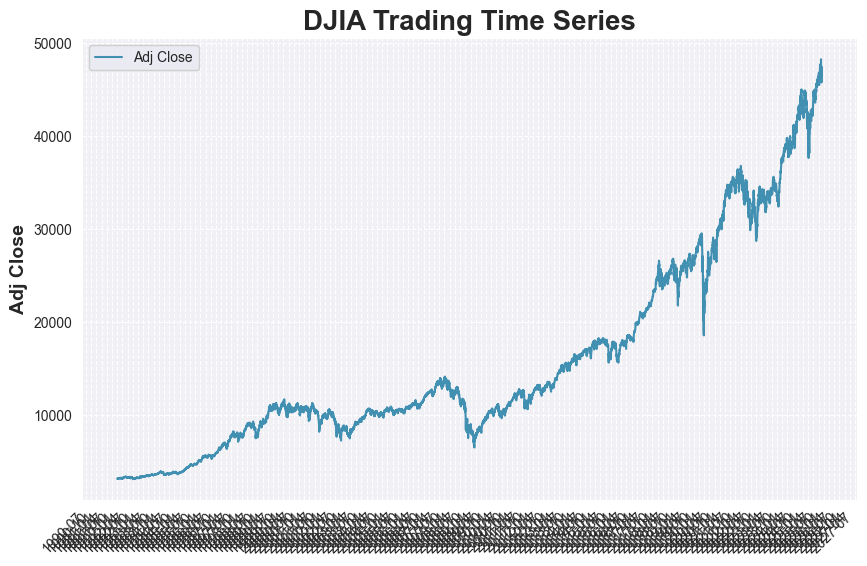

In [122]:
window = None
ax = plot_price(data, window)
plt.title("DJIA Trading Time Series", fontsize=20, fontweight='bold')




In [123]:
def plot_volume(data, window=None):
    _, ax = plt.subplots(figsize=(10, 6))
    red, green = '#DC3545', '#28A745'
    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]
    
    colors = [green if data.loc[i, 'Adj Close'] >= data.loc[i, 'Open'] 
            else red for i in range(len(data))]
    ax.bar(data['Date'], data['Volume'], color=colors, alpha=0.6, width=1)
    ax.set_ylabel('Volume', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Format x-axis dates for volume plot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


# plt.tight_layout()
# plt.show()


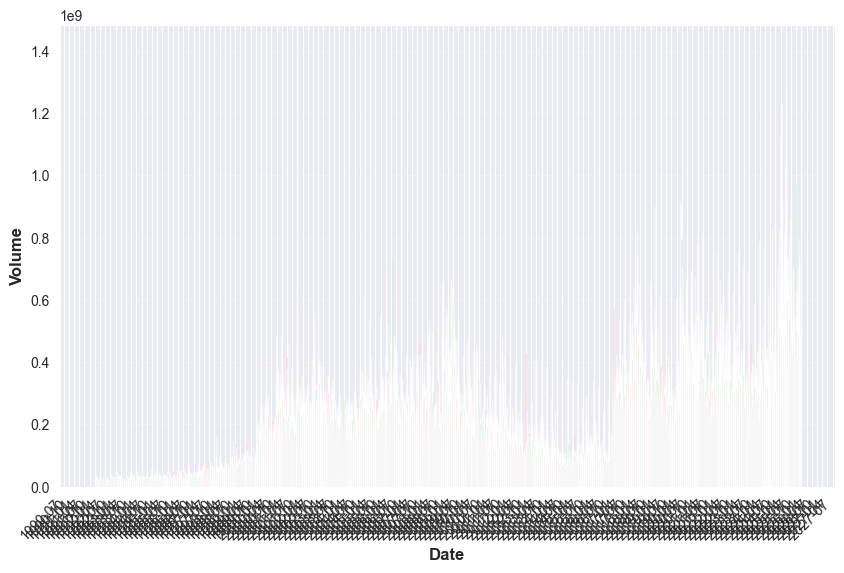

In [124]:
plot_volume(data)

### Dollar volume

In [125]:
data['Dollar Volume'] = data['Volume'] * data['Adj Close']/1e6
data['Dollar Volume'] 

0       7.471002e+04
1       7.561943e+04
2       8.729873e+04
3       8.175445e+04
4       9.304125e+04
            ...     
8534    3.655977e+07
8535    3.453800e+07
8536    3.056938e+07
8537    2.157839e+07
8538             NaN
Name: Dollar Volume, Length: 8539, dtype: float64

## Volatily Indicators

### Average True Range (ATR)

In [126]:
days = 14
atr = ta.atr(high=data['High'], 
            low=data['Low'], 
            close=data['Close'], 
            length=days)
data['ATR'] = atr.sub(atr.mean()).div(atr.std())


C:\Users\User\AppData\Local\Temp\ipykernel_11572\2543744271.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


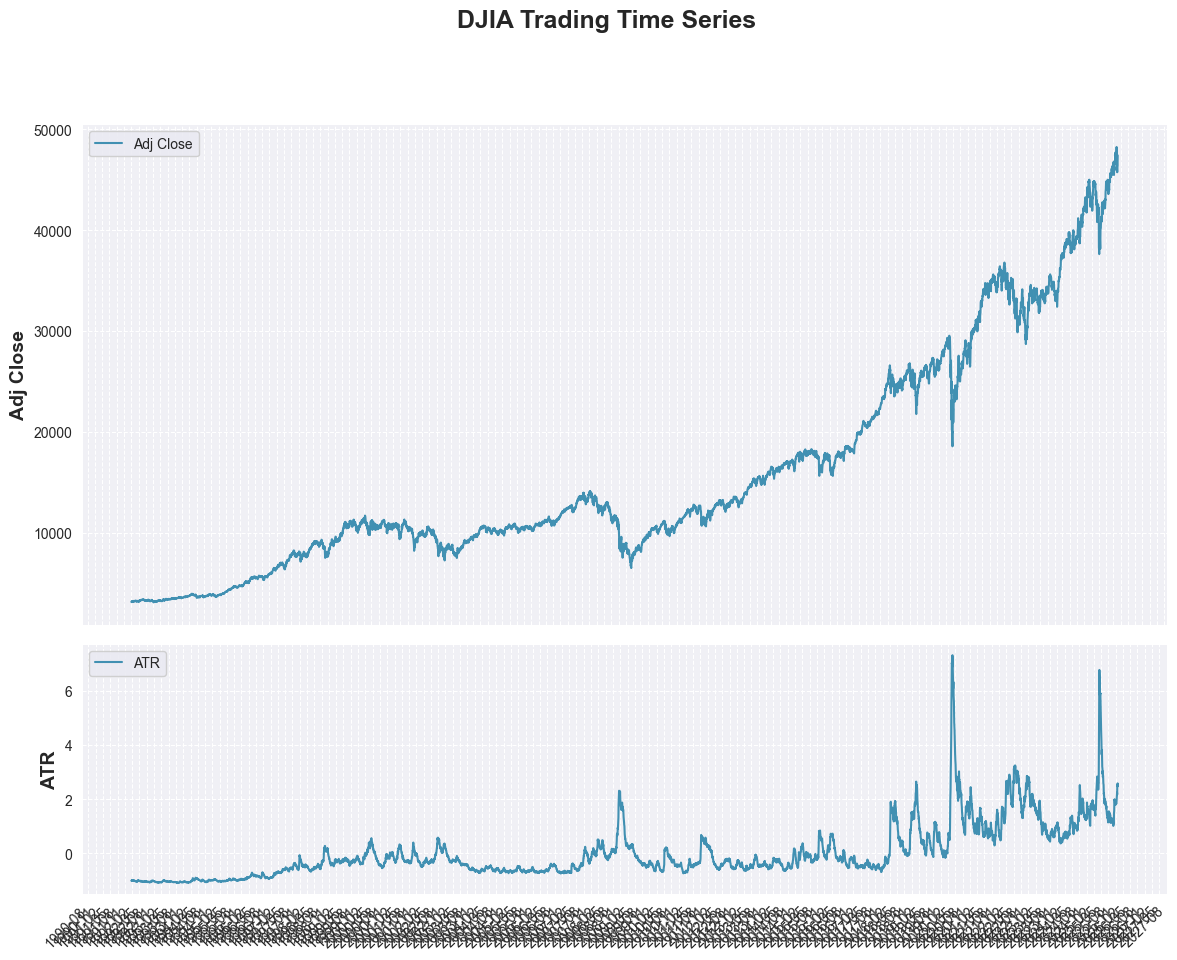

In [127]:
window = None

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Add title to the figure
fig.suptitle('DJIA Trading Time Series', fontsize=18, fontweight='bold', y=0.995)

# Plot Close price on top subplot
plot_price(data, window, x_ticks=False, col="Adj Close", ax=ax1)

# Plot ATR on bottom subplot
plot_price(data, window, x_ticks=True, col='ATR', ax=ax2)

plt.tight_layout()
plt.show()



### Bollinger Bands

- A volatility-based envelope around price
- They show volatility expansions and contractions and potential overbought/oversold conditions.

Maybe use log(Adj Close) before applying bbands (to have volatility in percentages.). The bands remain proportional to the asset's growth rate rather than its raw price level. (variance stabilization)

$ln(1+r) \approx r$ and $r = \frac{P_t - P_{t-1}}{P_t}$

**Conclusion:** The difference between log prices is approximately equal to the simple percentage return.

In [128]:
# from pandas_ta
bb_low_tab = ta.bbands(np.log1p(data['Adj Close']) , length=20, std=2)


In [129]:
days = 20
log_adj_close = np.log1p(data['Adj Close'])
sma = log_adj_close.rolling(window=days).mean()
k = 2
bb_low = sma - k * log_adj_close.rolling(window=days).std()
bb_high = sma + k * log_adj_close.rolling(window=days).std()
bb_mid = (bb_low + bb_high) / 2

data["bb_low"] = bb_low
data["bb_high"] = bb_high
data["bb_mid"] = bb_mid


### Garman-Klass Volatily (GKV) 

In [130]:
op_left = ((np.log(data['High']) - np.log(data['Low']))**2)/2 
op_right = (2*np.log(2)-1)*(np.log(data['Close']) - np.log(data['Open']))**2
data['GKV'] = op_left - op_right

### Moving Average Convergence Divergence (MACD)

It shows trend direction, strength, and momentum shifts.

- MACD line $= EMA_{12} - EMA_{26}$
- Signal line $= EMA_{9}(MACD line)$

In [131]:
days = 12
macd = ta.macd(data['Adj Close'], length=days).iloc[:, 0]
macd 
data["MACD"] = macd.sub(macd.mean()).div(macd.std())

## Momemtum indicators

### Relative Strenght Index (RSI)



A momentum oscillator from 0–100 measuring speed and magnitude of price changes.

Up periods:

- $U = close_{now} - close_{previous}$
- $D = 0$

Down periods:

- $U = 0$
- $D = close_{previous} - close_{now}$

$RSI = 100 - \frac{100}{1+RS}$, $RS=\frac{SMMA(U, n)}{SMMA(D, n)}$

In [132]:
#with pandas_ta
days = 14
data["RSI"] = ta.rsi(data['Adj Close'], length=days)


#with pandas

In [133]:
days = 14
smma = ta.smma(data['Adj Close'], length=days)

### Month return (To Finish)

- **to change, dataset smaller to compute month return**
- **consider week return or day return ?? both and will see after**

C:\Users\User\AppData\Local\Temp\ipykernel_11572\3524256042.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['return_1d'] = data[adj_col].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_11572\3524256042.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  raw = data[adj_col].pct_change(periods=days)
C:\Users\User\AppData\Local\Temp\ipykernel_11572\3524256042.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None

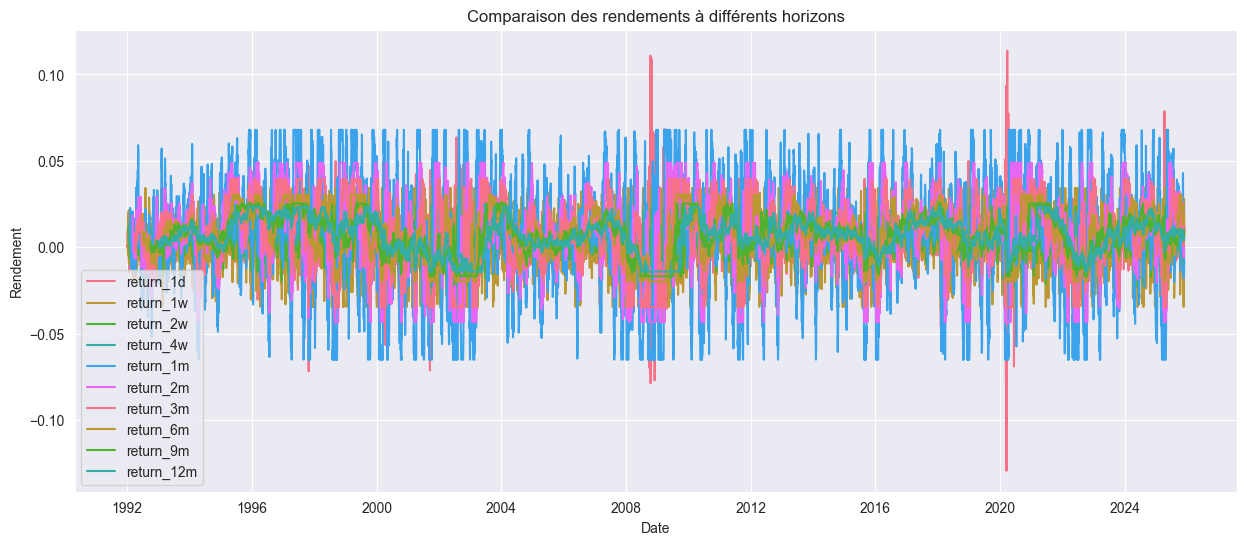

In [134]:
outlier_cutoff = 0.05
monthly_lags = [1, 2, 3, 6, 9, 12]  # months 21 trading days
weekly_lags  = [1, 2, 4]            # weeks 5 trading days

# rendement 1d (simple + log) sur colonne ajustée
data['return_1d'] = data[adj_col].pct_change()
data['log_return_1d'] = np.log(data[adj_col]).diff()

def _clean_and_mean_per_period(raw_series, periods, outlier_cutoff=0.05):
    # clippe extrêmes via quantiles puis convertit un rendement cumulé R over N periods
    # en rendement moyen par période (géométrique) : (1+R)^(1/N)-1
    clean = raw_series.clip(lower=raw_series.quantile(outlier_cutoff),
                             upper=raw_series.quantile(1 - outlier_cutoff))
    with np.errstate(divide='ignore', invalid='ignore'):
        per_period = (clean.add(1)).pow(1.0 / periods).sub(1)
    return per_period

# weekly returns (convertir change sur 5*lag jours -> rendement moyen par semaine)
for lag in weekly_lags:
    days = 5 * lag
    raw = data[adj_col].pct_change(periods=days)
    data[f'return_{lag}w'] = _clean_and_mean_per_period(raw, periods=lag, outlier_cutoff=outlier_cutoff)

# monthly returns (change sur ~21*lag jours -> rendement moyen par mois)
for lag in monthly_lags:
    days = int(round(21 * lag))
    raw = data[adj_col].pct_change(periods=days)
    data[f'return_{lag}m'] = _clean_and_mean_per_period(raw, periods=lag, outlier_cutoff=outlier_cutoff)

data.head()

data = data.set_index('Date')
cols = ['return_1d'] + \
       [f'return_{lag}w' for lag in weekly_lags] + \
       [f'return_{lag}m' for lag in monthly_lags]

plt.figure(figsize=(15,6))
for c in cols:
    plt.plot(data.index, data[c], label=c)

plt.title("Comparaison des rendements à différents horizons")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.show()



### Fama-french indicators